Problem statement: https://ovgu-ailab.github.io/lgm2021/ass3.html

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(28, 28)


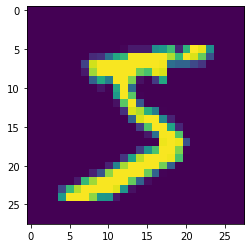

In [2]:
# Load MNIST Data set.
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_images.shape)
print(train_labels.shape)
print(train_images[0].shape)
#show the first image.
plt.imshow(train_images[0])

In [3]:
train_images[0].shape

(28, 28)

In [4]:
train_images[0] /255.0

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [5]:
from sklearn.preprocessing import Binarizer
bin = Binarizer(threshold=0.5)
nsamples , nx , ny = train_images.shape
train_images_reshaped = train_images.reshape(nsamples, nx*ny) / 255.0

In [6]:
train_images_reshaped = bin.fit_transform(train_images_reshaped)
print(train_images_reshaped.shape)
data = tf.data.Dataset.from_tensor_slices(train_images_reshaped.astype(np.float32))
data = data.shuffle(buffer_size=60000).batch(128,drop_remainder=True).repeat()


(60000, 784)


In [7]:
step_size = 0.001
gibbs_step = 1000
v_neurons = 784
h_neurons = 200
batch_size = 128

In [8]:
W = tf.Variable(tf.random.uniform([v_neurons,h_neurons],minval=-0.01,maxval=0.01))
#b = tf.Variable(tf.constant(value=0,dtype=tf.float32,shape=v_neurons))
b = tf.Variable(tf.random.uniform([1,784],minval=-0.01,maxval=0.01))
#c = tf.Variable(tf.constant(value=0,dtype=tf.float32,shape=h_neurons))
c = tf.Variable(tf.random.uniform([1,200],minval=-0.01,maxval=0.01))

In [9]:
W = tf.Variable(tf.random.truncated_normal([v_neurons,h_neurons],stddev=0.1))
b = tf.Variable(tf.zeros(shape=[1,784]))
#b = tf.Variable(tf.random.uniform([1,784],minval=-0.01,maxval=0.01))
c = tf.Variable(tf.zeros(shape=[1,200]))
#c = tf.Variable(tf.random.uniform([1,200],minval=-0.01,maxval=0.01))

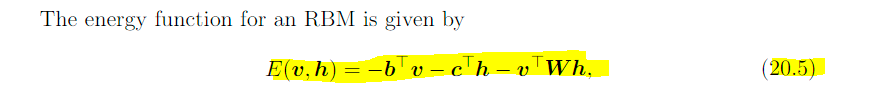

In [10]:

print(b.shape)
print(c.shape)
print(W.shape)


(1, 784)
(1, 200)
(784, 200)


In [11]:
N_dist = tfp.distributions.Normal(loc=0.0,scale=1.0)

In [12]:
def gibbs_update(v,h,gibbs_step):

  for _ in range(gibbs_step): # gibbs_step
    p_h_g_v = tf.nn.sigmoid(c + tf.matmul(v,W))
    #print(p_h_g_v.shape)
    h_hat = tfp.distributions.Bernoulli(probs=p_h_g_v).sample()
    h_hat = tf.cast(h_hat,dtype=tf.float32)
    #print("h_hat: ",h_hat.shape)

    p_v_g_h = tf.nn.sigmoid(b + tf.matmul(h_hat,W,transpose_b=True))
    #print(p_v_g_h.shape)
    v_hat = tfp.distributions.Bernoulli(probs=p_v_g_h).sample()
    v_hat = tf.cast(v_hat,dtype=tf.float32)
    #print("v_hat:",v_hat.shape)

    v , h = v_hat , h_hat
  
  return v,h, p_v_g_h


In [16]:
def RBM(epochs,gibbs_step,const_diversion=False):
  for epoch in range(epochs):
    for v in data:
      #print("v:",v.shape)
      # shape = 128 * 200
      p_h_g_v = tf.nn.sigmoid(c + tf.matmul(v,W))
      #print(p_h_g_v.shape)
      h = tfp.distributions.Bernoulli(probs=p_h_g_v).sample()
      h = tf.cast(h,dtype=tf.float32)
      #print("h: ",h.shape)
      #print(h)
      with tf.GradientTape(persistent=True) as tape:
        tape.watch([W,b,c])
        E_P = - tf.matmul(v,b,transpose_b=True) - tf.matmul(h,c,transpose_b=True) - tf.matmul(h,(tf.matmul(v,W)),transpose_b=True)
        #E_3 = tf.matmul(h,(tf.matmul(v,W)),transpose_b=True)
      
        print("Positive phase E_P: ",E_P.shape)
        #print("E_3:",E_3.shape)
        dE_dW_p, dE_db_p,dE_dc_p  = tape.gradient(E_P,[W,b,c])

        if const_diversion == True:
          v_n = tf.data.experimental.sample_from_datasets(v)       
        else:
          v_n = N_dist.sample(sample_shape=(128,784))

        v_hat , h_hat , recontsruct = gibbs_update(v_n,h,gibbs_step)

        #with tf.GradientTape() as tape1:
        E_N = - tf.matmul(v_hat,b,transpose_b=True) - tf.matmul(h_hat,c,transpose_b=True) - tf.matmul(h_hat,(tf.matmul(v_hat,W)),transpose_b=True)
        print("Negative phase E_N: ",E_N.shape)
        dE_dW_n, dE_db_n, dE_dc_n = tape.gradient(E_N,[W,b,c])

        # print("dE_dW_p: ",dE_dW_p.shape)
        # print("dE_dW_n: ",dE_dW_n.shape)
        print("dE_dW_p val: ",dE_dW_p)
        delta_W = dE_dW_p - dE_dW_n
        # print("dE_db_p: ",dE_db_p.shape)
        # print("dE_db_n: ",dE_db_n.shape)
        print("dE_db_p val: ",dE_db_p)
        delta_b = dE_db_p - dE_db_n
        # print("dE_dc_p: ",dE_dc_p.shape)
        # print("dE_dc_n: ",dE_dc_n.shape)
        print("dE_dc_p vals: ",dE_dc_p)
        delta_c = dE_dc_p - dE_dc_n

        W.assign_add(step_size*delta_W)
        b.assign_add(step_size*delta_b)
        c.assign_add(step_size*delta_c)
        

        print("delta_W: ",delta_W)



    
    
      
    
    

In [18]:
RBM(10,gibbs_step)

Positive phase E_P:  (128, 128)
Negative phase E_N:  (128, 128)
dE_dW_p val:  tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(784, 200), dtype=float32)
dE_db_p val:  tf.Tensor(
[[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.  -128.  -128.  -128.  -256.  -128.     0.
   -128.  -128.     0.  -128.     0.  -128.  -128.  -128.  -128.  -128.
   -128.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.  -128.  -128.  -256.  -384.  -51

KeyboardInterrupt: ignored